# Faster R-CNN модификация 3
Источники:
- https://www.nature.com/articles/s41598-025-12740-x
- https://www.sciencedirect.com/science/article/pii/S2590123024007424

Улучшения:
- Деформируемые свертки из модификации 1;
- Модуль усиленного слияния признаков (FFM);
- Легковесный механизм внимания по каналам (LCAM).

# Импорт библиотек

In [1]:
!pip install -q kagglehub tqdm
!pip install torchmetrics
!pip install -U gdown -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 29.6 MB/s eta 0:00:00


In [2]:
import os
import json
import random
from collections import Counter

import yaml
import kagglehub
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import deform_conv2d

from torchvision.models.detection import (
    fasterrcnn_resnet50_fpn,
    FasterRCNN_ResNet50_FPN_Weights,
    FasterRCNN
)
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator

from torchmetrics.detection import MeanAveragePrecision
import matplotlib.pyplot as plt

import gdown

import math


# Загрузка датасета

Используемый датасет предоставлен в формате YOLOv11

In [3]:
path = kagglehub.dataset_download("romankornyushenkov/neu-det-v5")
print("Path to dataset files:", path)

yaml_path = os.path.join(path, "data.yaml")
with open(yaml_path, 'r') as f:
    data_config = yaml.safe_load(f)

print("Классы:", data_config['names'])
print("Число классов:", len(data_config['names']))

100%|██████████| 12.1M/12.1M [00:00<00:00, 91.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/romankornyushenkov/neu-det-v5/versions/1
Классы: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in-scale', 'scratches']
Число классов: 6


Перевод датасета в нужный формат

In [4]:
def yolo_to_bbox(yolo_line, img_width, img_height):
    parts = yolo_line.strip().split()
    class_id = int(parts[0]) + 1
    x_center = float(parts[1]) * img_width
    y_center = float(parts[2]) * img_height
    box_w = float(parts[3]) * img_width
    box_h = float(parts[4]) * img_height

    x1 = max(0, x_center - box_w / 2)
    y1 = max(0, y_center - box_h / 2)
    x2 = min(img_width, x_center + box_w / 2)
    y2 = min(img_height, y_center + box_h / 2)
    return [x1, y1, x2, y2], class_id

class MetalDefectDatasetCached(torch.utils.data.Dataset):
    def __init__(self, img_dir, label_dir, cache_images=True):
        self.img_dir = img_dir
        self.imgs = sorted([
            f for f in os.listdir(img_dir)
            if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ])
        self.transform = transforms.ToTensor()
        self.cache_images = cache_images

        print(f"Кэшируем аннотации для {len(self.imgs)} изображений..")
        self.cached_annotations = []
        self.cached_images = [] if cache_images else None

        for img_name in tqdm(self.imgs, desc="Подготовка данных"):
            img_path = os.path.join(img_dir, img_name)
            img_pil = Image.open(img_path).convert("RGB")
            img_width, img_height = img_pil.size

            if cache_images:
                self.cached_images.append(self.transform(img_pil))

            label_path = os.path.join(label_dir, os.path.splitext(img_name)[0] + '.txt')
            boxes, labels = [], []
            if os.path.exists(label_path):
                with open(label_path) as f:
                    for line in f:
                        if line.strip():
                            bbox, label = yolo_to_bbox(line, img_width, img_height)
                            boxes.append(bbox)
                            labels.append(label)

            boxes_tensor = torch.as_tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4))
            labels_tensor = torch.as_tensor(labels, dtype=torch.int64) if labels else torch.zeros(0, dtype=torch.int64)
            self.cached_annotations.append({'boxes': boxes_tensor, 'labels': labels_tensor})

            if not cache_images:
                img_pil.close()

        print(f" Данные подготовлены. Кэширование изображений: {cache_images}")

    def __getitem__(self, idx):
        if self.cache_images:
            img = self.cached_images[idx]
        else:
            img_path = os.path.join(self.img_dir, self.imgs[idx])
            img = Image.open(img_path).convert("RGB")
            img = self.transform(img)

        return img, self.cached_annotations[idx]

    def __len__(self):
        return len(self.imgs)


In [5]:
train_img_dir = os.path.join(path, "train", "images")
train_label_dir = os.path.join(path, "train", "labels")
val_img_dir = os.path.join(path, "valid", "images")
val_label_dir = os.path.join(path, "valid", "labels")
test_img_dir = os.path.join(path, "test", "images")
test_label_dir = os.path.join(path, "test", "labels")

In [6]:
train_dataset = MetalDefectDatasetCached(train_img_dir, train_label_dir)
val_dataset = MetalDefectDatasetCached(val_img_dir, val_label_dir)
test_dataset = MetalDefectDatasetCached(test_img_dir, test_label_dir)

Кэшируем аннотации для 1260 изображений..


Подготовка данных: 100%|██████████| 1260/1260 [00:04<00:00, 279.03it/s]


 Данные подготовлены. Кэширование изображений: True
Кэшируем аннотации для 359 изображений..


Подготовка данных: 100%|██████████| 359/359 [00:00<00:00, 488.06it/s]


 Данные подготовлены. Кэширование изображений: True
Кэшируем аннотации для 180 изображений..


Подготовка данных: 100%|██████████| 180/180 [00:00<00:00, 365.47it/s]

 Данные подготовлены. Кэширование изображений: True


In [7]:
# Объединяем train и valid
full_train_dataset = ConcatDataset([train_dataset, val_dataset])

In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True
)

full_train_dataloader = DataLoader(
    full_train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn
)

## Пример тренировочных данных

/usr/local/lib/python3.12/dist-packages/torchvision/utils.py:375: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


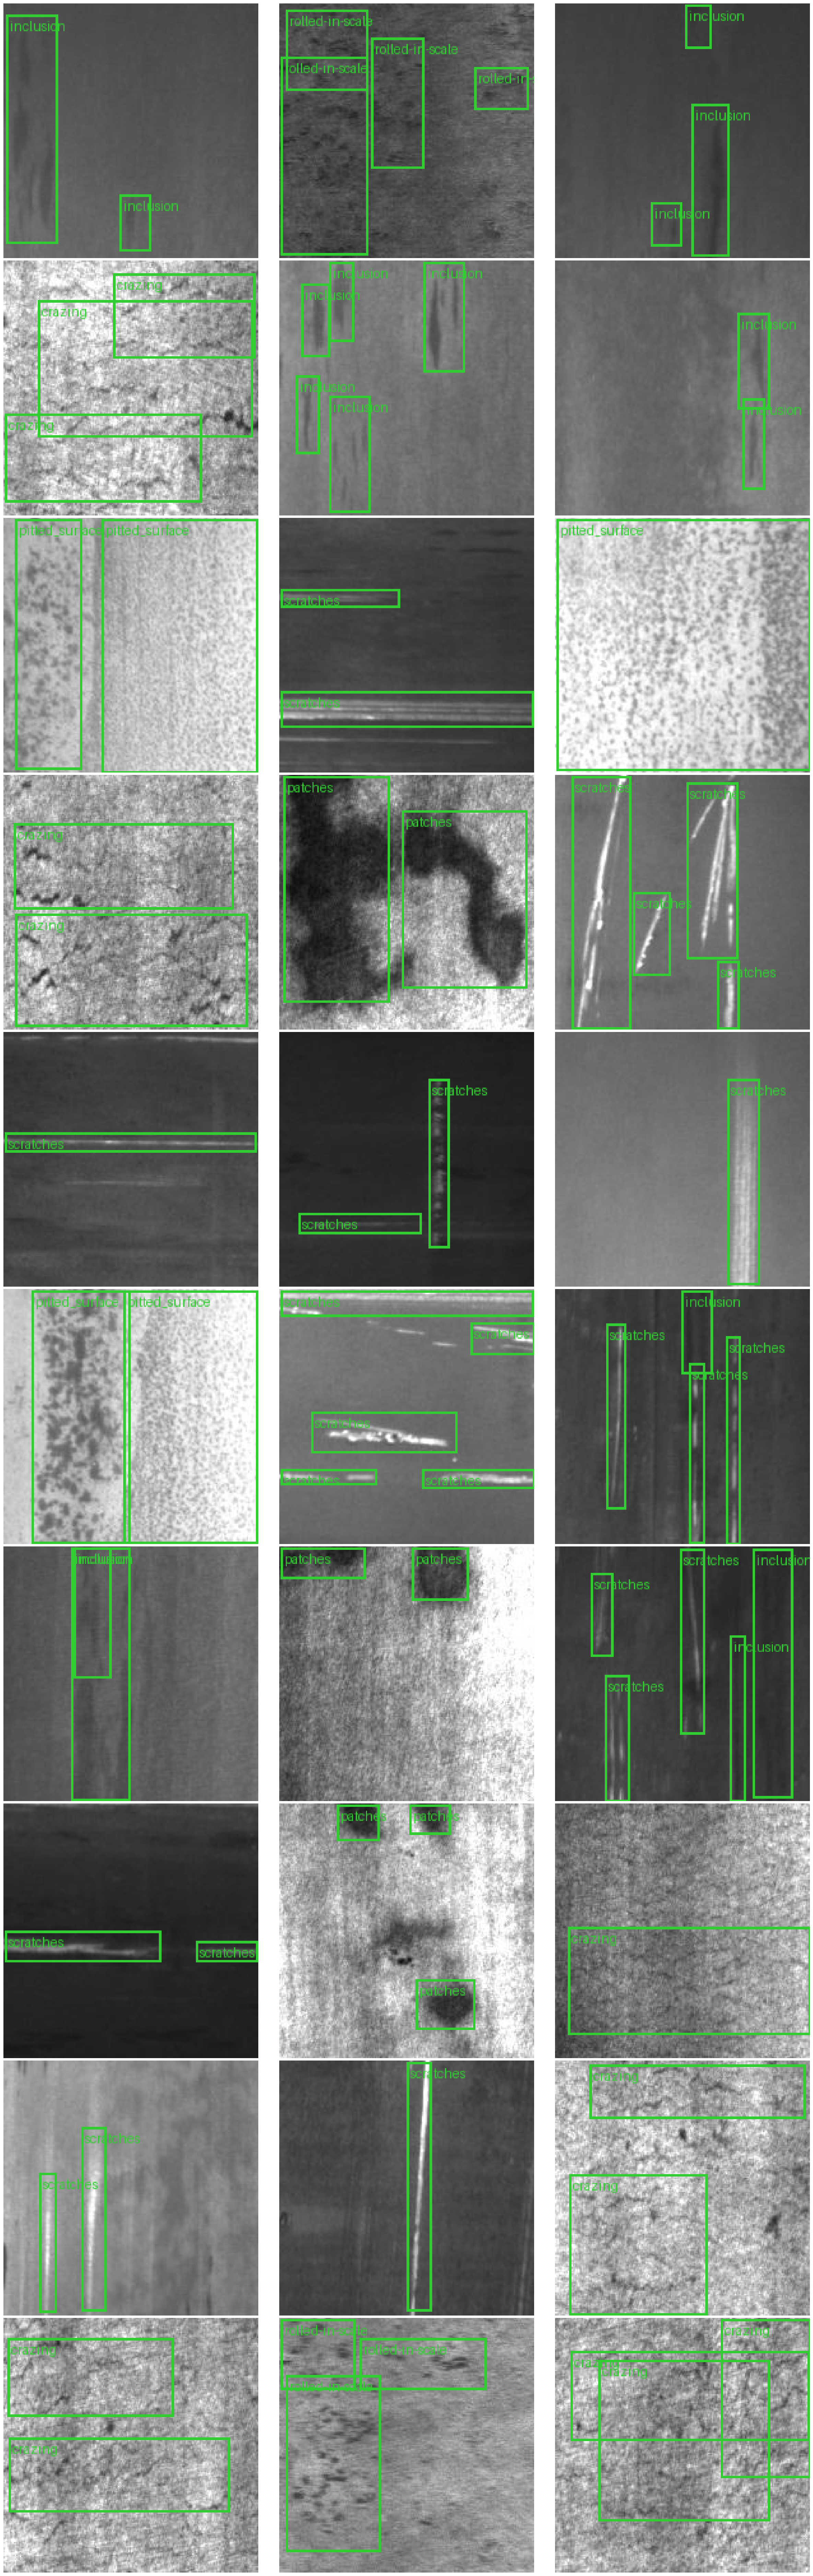

In [9]:
class_names = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in-scale', 'scratches']
indices = random.sample(range(len(full_train_dataset)), k=30)

fig, axes = plt.subplots(10, 3, figsize=(25, 75))
axes = axes.flatten()

for i, idx in enumerate(indices):
    img, target = full_train_dataset[idx]
    img_uint8 = (img * 255).to(torch.uint8)

    boxes = target['boxes']
    labels = target['labels']

    if len(labels) > 0:
        label_names = [class_names[lb.item() - 1] for lb in labels]
    else:
        label_names = []

    img_with_boxes = draw_bounding_boxes(
        image=img_uint8,
        boxes=boxes,
        labels=label_names,
        colors='limegreen',
        width=2,
        font_size=12
    )

    axes[i].imshow(img_with_boxes.permute(1, 2, 0))
    axes[i].axis('off')

plt.tight_layout(pad=0.5)
plt.show()

# Создание модели

## Загрузка базовой модели

In [10]:
base_model = fasterrcnn_resnet50_fpn(
    weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT,
    trainable_backbone_layers=5
)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


100%|██████████| 160M/160M [00:00<00:00, 196MB/s]


## Деформируемые свертки

In [11]:
class DeformConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1,
                 padding=1, dilation=1, groups=1):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation

        # Свёртка для предсказания offset'ов
        self.conv_offset = nn.Conv2d(
            in_channels,
            2 * kernel_size * kernel_size,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            bias=True
        )

        # Основные веса свёртки
        self.weight = nn.Parameter(torch.Tensor(
            out_channels, in_channels, kernel_size, kernel_size
        ))
        self.bias = nn.Parameter(torch.Tensor(out_channels))

        # Инициализация
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        nn.init.zeros_(self.bias)
        nn.init.zeros_(self.conv_offset.weight)
        nn.init.zeros_(self.conv_offset.bias)

    def forward(self, x):
        offset = self.conv_offset(x)
        return deform_conv2d(
            x,
            offset,
            self.weight,
            self.bias,
            stride=self.stride,
            padding=self.padding,
            dilation=self.dilation
        )

In [12]:
def replace_conv_with_deformable(module):
    for name, child in module.named_children():
        if isinstance(child, nn.Conv2d) and child.kernel_size == (3, 3):

            deform_conv = DeformConv2d(
                in_channels=child.in_channels,
                out_channels=child.out_channels,
                kernel_size=child.kernel_size[0],
                stride=child.stride,
                padding=child.padding,
                dilation=child.dilation,
                groups=child.groups
            )

            deform_conv.weight.data.copy_(child.weight.data)
            if child.bias is not None:
                deform_conv.bias.data.copy_(child.bias.data)
            setattr(module, name, deform_conv)
        else:
            replace_conv_with_deformable(child)

## Модуль усиленного слияния признаков (FFM)



In [13]:
class FeatureFusionModule(nn.Module):
    def __init__(self, in_channels=256):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, p2, p3):
        p3_up = torch.nn.functional.interpolate(
            p3, size=p2.shape[-2:], mode='bilinear', align_corners=False
        )
        p3_up = self.conv(p3_up)
        fused = p2 + p3_up
        fused = self.bn(fused)
        fused = self.relu(fused)
        return fused

## Легковесный механизм внимания по каналам (LCAM)


In [14]:
class LCAM(nn.Module):
    def __init__(self, in_channels=256, reduction=2):
        super().__init__()
        reduced_channels = in_channels // reduction
        self.conv1 = nn.Conv2d(in_channels, reduced_channels, kernel_size=3, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(reduced_channels, in_channels, kernel_size=3, padding=1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        attention = self.conv1(x)
        attention = self.relu(attention)
        attention = self.conv2(attention)
        attention = self.sigmoid(attention)
        return x * attention

## Создание нового бэкбона с FFM, LCAM и деформируемыми свертками

In [15]:
class CustomBackboneWithFusion(nn.Module):
    def __init__(self, original_fpn):
        super().__init__()
        self.fpn = original_fpn
        self.fusion = FeatureFusionModule(in_channels=256)
        self.lcam_p2 = LCAM(in_channels=256)
        self.lcam_p3 = LCAM(in_channels=256)
        self.lcam_p4 = LCAM(in_channels=256)
        self.lcam_p5 = LCAM(in_channels=256)
        self.out_channels = 256

    def forward(self, x):
        fpn_outs = self.fpn(x)

        p2 = fpn_outs['0']
        p3 = fpn_outs['1']

        fused_p2 = self.fusion(p2, p3)

        out_p2 = self.lcam_p2(fused_p2)
        out_p3 = self.lcam_p3(fpn_outs['1'])
        out_p4 = self.lcam_p4(fpn_outs['2'])
        out_p5 = self.lcam_p5(fpn_outs['3'])

        out = {
            '0': out_p2,
            '1': out_p3,
            '2': out_p4,
            '3': out_p5
        }
        return out

In [16]:
replace_conv_with_deformable(base_model.backbone.body.layer2)
replace_conv_with_deformable(base_model.backbone.body.layer3)
replace_conv_with_deformable(base_model.backbone.body.layer4)

## Сборка улучшенной модели

In [17]:
custom_backbone = CustomBackboneWithFusion(base_model.backbone)

In [18]:
in_features = base_model.roi_heads.box_predictor.cls_score.in_features
base_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=7)

In [19]:
anchor_sizes = ((32,), (64,), (128,), (256,))
aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
new_anchor_generator = AnchorGenerator(sizes=anchor_sizes, aspect_ratios=aspect_ratios)

In [20]:
model = FasterRCNN(
    backbone=custom_backbone,
    rpn_anchor_generator=new_anchor_generator,
    rpn_head=base_model.rpn.head,
    box_roi_pool=base_model.roi_heads.box_roi_pool,
    box_head=base_model.roi_heads.box_head,
    box_predictor=base_model.roi_heads.box_predictor,
    box_detections_per_img=100
)

In [21]:
model.eval()
with torch.no_grad():
    dummy_input = [torch.randn(3, 640, 640)]
    output = model(dummy_input)
print("Forward pass успешен")

Forward pass успешен


# Обучение модели

In [22]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): CustomBackboneWithFusion(
    (fpn): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=0.0)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64, eps=0.0)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
           

In [23]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.0001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.9)


In [28]:
num_epochs = 50 #поставить необходимое количество

for epoch in range(num_epochs):
    print(f"\n Epoch {epoch+1}/{num_epochs}")

    model.train()
    total_loss = 0

    progress_bar = tqdm(full_train_dataloader, desc="Training", leave=False)
    for batch_idx, (images, targets) in enumerate(progress_bar):

        images = [img.to(device, non_blocking=True) for img in images]
        targets = [{k: v.to(device, non_blocking=True) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()
        progress_bar.set_postfix({
            'batch_loss': f"{losses.item():.4f}",
            'avg_loss': f"{total_loss / (batch_idx + 1):.4f}"
        })

    avg_train_loss = total_loss / len(full_train_dataloader)

    lr_scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1} finished | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"LR: {current_lr:.6f}")


 Epoch 1/50


KeyboardInterrupt: 

## Полный чекпонит после обучения

Сохраняем полный чекпоинт для возможности продолжения обучения модели начиная с последней эпохи

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': lr_scheduler.state_dict(),
}, f"faster_rcnn_neu_det_v5_FFM_LCAM_Deform_lr_0.0001_STPLR_4_0.9_EP_{epoch}.pth") #сохранение локально, поменять путь при сохранении на Google Disk
print(f"Файл сохранен как: faster_rcnn_neu_det_v5_FFM_LCAM_Deform_lr_0.0001_STPLR_4_0.9_EP_{epoch}.pth")

Файл сохранен как: faster_rcnn_neu_det_v5_FFM_LCAM_Deform_lr_0.0001_STPLR_4_0.9_EP_0.pth


# Загрузка чекпоинта и тестирование модели

Создаем новый экземпляр модели

In [24]:
model_test = FasterRCNN(
    backbone=custom_backbone,
    rpn_anchor_generator=new_anchor_generator,
    rpn_head=base_model.rpn.head,
    box_roi_pool=base_model.roi_heads.box_roi_pool,
    box_head=base_model.roi_heads.box_head,
    box_predictor=base_model.roi_heads.box_predictor,
    box_detections_per_img=100
)

In [25]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_test.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): CustomBackboneWithFusion(
    (fpn): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=0.0)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64, eps=0.0)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
           

Загружаем лучший чекпоинт для тестирования

In [26]:
file_id = "1vT4qa5hKlyREMR96Sh0z5CalltRApCfU"
output_filename = "faster_rcnn_neu_det_v5_FFM_LCAM_Deform_lr_0.0001_STPLR_4_0.9_EP_74.pth"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output_filename, quiet=False, fuzzy=True)

checkpoint_path = output_filename
#checkpoint_path = "/content/drive/MyDrive/Datasets/faster_rcnn_neu_det_v5_FFM_LCAM_Deform_lr_0.0001_STPLR_4_0.9_EP_74" #При скачивании со своего Google Disk
#checkpoint_path = "faster_rcnn_neu_det_v5_FFM_LCAM_Deform_lr_0.0001_STPLR_4_0.9_EP_74" #При локальном расположении файла чекпоинта
print(f"Файл скачан: {checkpoint_path}")

Downloading...
From (original): https://drive.google.com/uc?id=1vT4qa5hKlyREMR96Sh0z5CalltRApCfU
From (redirected): https://drive.google.com/uc?id=1vT4qa5hKlyREMR96Sh0z5CalltRApCfU&confirm=t&uuid=ccaadd9d-4f50-43b5-a554-bc802be28aae
To: /content/faster_rcnn_neu_det_v5_FFM_LCAM_Deform_lr_0.0001_STPLR_4_0.9_EP_74.pth
100%|██████████| 359M/359M [00:03<00:00, 91.0MB/s]

Файл скачан: faster_rcnn_neu_det_v5_FFM_LCAM_Deform_lr_0.0001_STPLR_4_0.9_EP_74.pth


In [27]:
checkpoint = torch.load(checkpoint_path, map_location=device)

In [28]:
model_test.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Тестирование модели при пороге IoU = 0.5

In [32]:
class_names = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in-scale', 'scratches']

metric = MeanAveragePrecision(
    box_format='xyxy',
    iou_thresholds=[0.5],
    class_metrics=True,
    compute_on_cpu=True,
    extended_summary=True
)

model_test.eval()

for images, targets in tqdm(test_loader, desc="Testing"):
    images = [img.to(device) for img in images]

    with torch.no_grad():
        outputs = model_test(images)

    preds = []
    target_list = []
    for i in range(len(outputs)):
        pred = {
            'boxes': outputs[i]['boxes'].cpu(),
            'scores': outputs[i]['scores'].cpu(),
            'labels': outputs[i]['labels'].cpu()
        }
        target = {
            'boxes': targets[i]['boxes'].cpu(),
            'labels': targets[i]['labels'].cpu()
        }
        preds.append(pred)
        target_list.append(target)

    metric.update(preds, target_list)

results = metric.compute()

print("Результат оценки:")
print(" ")
print(f"mAP@0.5:       {results['map_50']:.4f}")

prec = results['precision']
rec = results['recall']

if prec.numel() > 0 and not torch.isnan(prec).all():
    avg_prec = prec[prec >= 0].mean().item()
else:
    avg_prec = 0.0

if rec.numel() > 0 and not torch.isnan(rec).all():
    avg_rec = rec[rec >= 0].mean().item()
else:
    avg_rec = 0.0

avg_f1 = 2 * (avg_prec * avg_rec) / (avg_prec + avg_rec)

print(f"Precision:     {avg_prec:.4f}")
print(f"Recall:        {avg_rec:.4f}")
print(f"F1:            {avg_f1:.4f}")

print(" ")
print("Метрики по классам (AP@0.5)")
print(" ")

map_per_class = results['map_per_class']
for i, class_name in enumerate(class_names):
    ap = map_per_class[i].item()
    if not torch.isnan(torch.tensor(ap)):
        print(f"{class_name:<18}: {ap:.4f}")
    else:
        print(f"{class_name:<18}: N/A")

Testing: 100%|██████████| 180/180 [00:19<00:00,  9.19it/s]


Результат оценки:
 
mAP@0.5:       0.7832
Precision:     0.6198
Recall:        0.7626
F1:            0.6838
 
Метрики по классам (AP@0.5)
 
crazing           : 0.3863
inclusion         : 0.8826
patches           : 0.9504
pitted_surface    : 0.8832
rolled-in-scale   : 0.6154
scratches         : 0.9814


Тестирование модели при порогах IoU [0.5-0.95]

In [33]:
from torchmetrics.detection import MeanAveragePrecision
import torch
from pprint import pprint
from tqdm import tqdm

class_names = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in-scale', 'scratches']

map_metric = MeanAveragePrecision(
    box_format='xyxy',
    class_metrics=True,
    compute_on_cpu=True,
    extended_summary=True
)

model_test.eval()

for images, targets in tqdm(test_loader, desc="Testing"):
    images = [img.to(device) for img in images]

    with torch.no_grad():
        outputs = model_test(images)

    preds = []
    target_list = []
    for i in range(len(outputs)):
        pred = {
            'boxes': outputs[i]['boxes'].cpu(),
            'scores': outputs[i]['scores'].cpu(),
            'labels': outputs[i]['labels'].cpu()
        }
        target = {
            'boxes': targets[i]['boxes'].cpu(),
            'labels': targets[i]['labels'].cpu()
        }
        preds.append(pred)
        target_list.append(target)

    map_metric.update(preds, target_list)

results = map_metric.compute()

print("Результат оценки:")
print(" ")
#print(f"mAP@0.5:       {results['map_50']:.4f}")
print(f"mAP@0.5-0.95:  {results['map']:.4f}")


prec = results['precision']
rec = results['recall']

if prec.numel() > 0 and not torch.isnan(prec).all():
    avg_prec = prec[prec >= 0].mean().item()
else:
    avg_prec = 0.0

if rec.numel() > 0 and not torch.isnan(rec).all():
    avg_rec = rec[rec >= 0].mean().item()
else:
    avg_rec = 0.0

avg_f1 = 2 * (avg_prec * avg_rec) / (avg_prec + avg_rec)

print(f"Precision:     {avg_prec:.4f}")
print(f"Recall:        {avg_rec:.4f}")
print(f"F1:            {avg_f1:.4f}")

print(" ")
print("Метрики по классам (AP@0.5-0.95)")
print(" ")

map_per_class = results['map_per_class']
for i, class_name in enumerate(class_names):
    ap = map_per_class[i].item()
    if not torch.isnan(torch.tensor(ap)):
        print(f"{class_name:<18}: {ap:.4f}")
    else:
        print(f"{class_name:<18}: N/A")

Testing: 100%|██████████| 180/180 [00:19<00:00,  9.05it/s]


Результат оценки:
 
mAP@0.5-0.95:  0.4352
Precision:     0.3388
Recall:        0.4325
F1:            0.3800
 
Метрики по классам (AP@0.5-0.95)
 
crazing           : 0.1309
inclusion         : 0.4846
patches           : 0.6295
pitted_surface    : 0.5601
rolled-in-scale   : 0.2511
scratches         : 0.5548


## Визуализация предсказаний модели

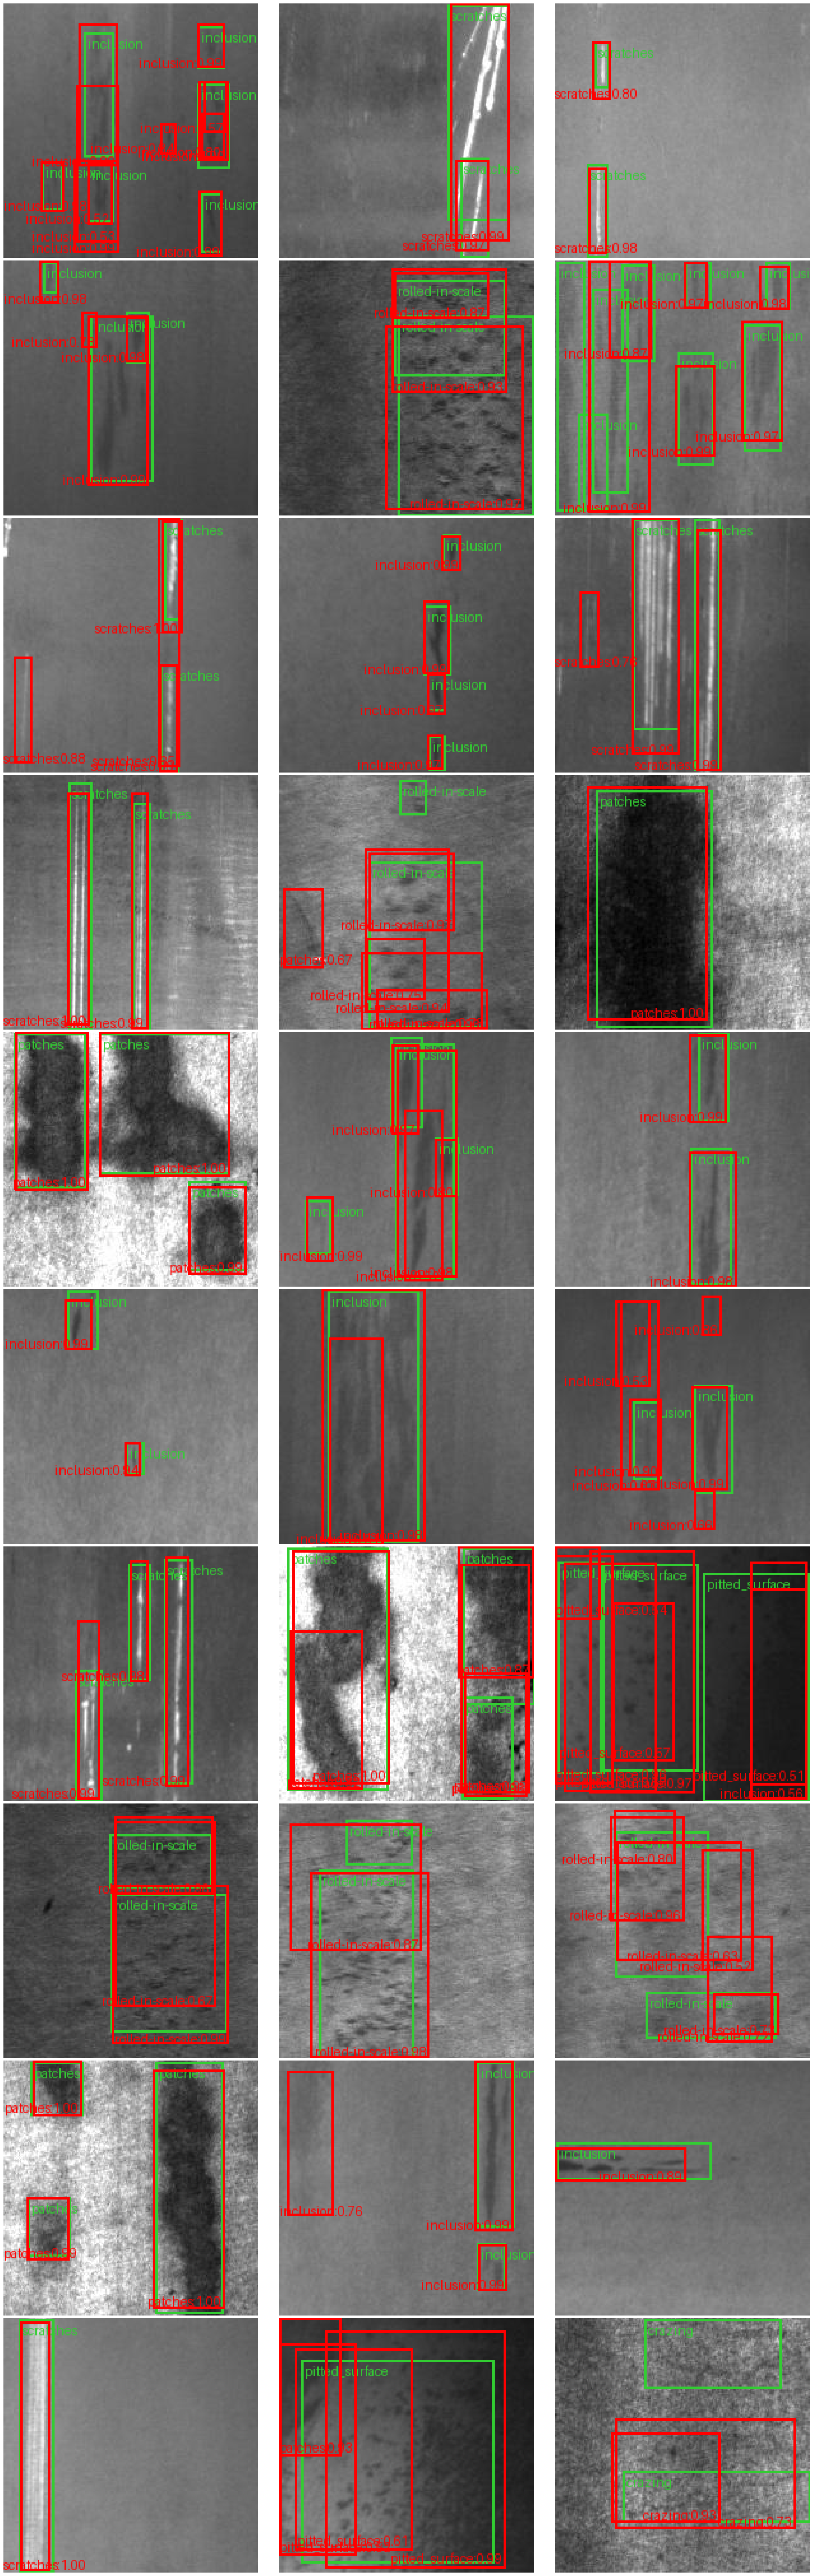

In [30]:
model_test.eval()

class_names = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in-scale', 'scratches']

indices = random.sample(range(len(test_dataset)), k=30)

fig, axes = plt.subplots(10, 3, figsize=(25, 75))
axes = axes.flatten()

with torch.no_grad():
    for i, idx in enumerate(indices):
        img, target = test_dataset[idx]
        img_tensor = img.unsqueeze(0).to(device)

        model_output = model_test(img_tensor)[0]

        gt_boxes = target['boxes']
        gt_labels = target['labels']
        gt_label_names = [class_names[lb.item() - 1] for lb in gt_labels] if len(gt_labels) > 0 else []

        img_uint8 = (img * 255).to(torch.uint8)
        img_with_gt = draw_bounding_boxes(
            image=img_uint8,
            boxes=gt_boxes,
            labels=gt_label_names,
            colors='limegreen',
            width=2,
            font_size=14
        )

        pred_boxes = model_output['boxes']
        pred_scores = model_output['scores']
        pred_labels = model_output['labels']

        keep = pred_scores >= 0.5
        pred_boxes = pred_boxes[keep].cpu()
        pred_labels = pred_labels[keep].cpu()
        pred_scores = pred_scores[keep].cpu()

        img_pil = transforms.ToPILImage()(img_with_gt)
        draw = ImageDraw.Draw(img_pil)

        try:
            font = ImageFont.truetype("DejaVuSans.ttf", 14)
        except:
            font = ImageFont.load_default()

        for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
            x1, y1, x2, y2 = box.tolist()
            class_name = class_names[label.item() - 1]
            text = f"{class_name}:{score:.2f}"

            draw.rectangle([x1, y1, x2, y2], outline='red', width=2)

            bbox = draw.textbbox((0, 0), text, font=font)
            text_width = bbox[2] - bbox[0]
            text_height = bbox[3] - bbox[1]

            text_x = x2 - text_width - 2
            text_y = y2 - text_height - 2

            text_x = max(0, text_x)
            text_y = max(0, text_y)

            draw.text((text_x, text_y), text, fill='red', font=font)

        final_img = transforms.ToTensor()(img_pil)
        axes[i].imshow(final_img.permute(1, 2, 0))
        axes[i].axis('off')

plt.tight_layout(pad=0.5)
plt.show()

# Продолжение обучения модели, используя чекпоинт

In [31]:
params = [p for p in model_test.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.0001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.9)

In [32]:
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
lr_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

In [33]:
start_epoch = checkpoint['epoch']
start_epoch

74

In [ ]:
total_epochs = 100 #поставить необходимое количество

print(f"Загружено состояние после {start_epoch} эпох")
print(f"Продолжаем обучение с эпохи {start_epoch} до {total_epochs}")
print(f"Текущий LR: {optimizer.param_groups[0]['lr']:.8f}")

for epoch in range(start_epoch, total_epochs):
    print(f"\n Epoch {epoch+1}/{total_epochs}")

    model_test.train()
    total_loss = 0

    progress_bar = tqdm(full_train_dataloader, desc="Training", leave=False)
    for batch_idx, (images, targets) in enumerate(progress_bar):
        images = [img.to(device, non_blocking=True) for img in images]
        targets = [{k: v.to(device, non_blocking=True) for k, v in t.items()} for t in targets]

        loss_dict = model_test(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()
        progress_bar.set_postfix({
            'batch_loss': f"{losses.item():.4f}",
            'avg_loss': f"{total_loss / (batch_idx + 1):.4f}"
        })

    avg_train_loss = total_loss / len(full_train_dataloader)

    lr_scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1} finished | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"LR: {current_lr:.6f}")

In [ ]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model_test.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': lr_scheduler.state_dict(),
}, f"faster_rcnn_neu_det_v5_FFM_LCAM_Deform_lr_0.0001_STPLR_4_0.9_EP_{epoch}.pth") #сохранение локально, поменять путь при сохранении на Google Disk
print(f"Файл сохранен как: faster_rcnn_neu_det_v5_FFM_LCAM_Deform_lr_0.0001_STPLR_4_0.9_EP_{epoch}.pth")